# Import Libraries

In [1]:
import nibabel as nib
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f
from scipy.ndimage import rotate
#import re
#from matplotlib import cm
#from matplotlib.colors import Normalize

# Define Functions

In [2]:
# Function to load NIfTI images
def load_nii(filename):
    return nib.load(filename)

In [3]:
# Function for power and statistic p-value calculations
def power_calcs2(df1, df2, f2, alpha):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    lambda_ = (df1 + df2 + 1) * f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return power

In [4]:
# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z

In [5]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, f2, n, alpha, df, verbose=True):
    """
    Calculate second-generation p-value for neuroimaging data

    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value (0)
        effect_interval (float): Interval of practically equivalent effects (User provides this - we need to test this value)
        f2 (float): Cohen's f-squared effect size
        n (int): Sample size
        alpha (float): Significance level
        df (int): Degrees of freedom
        verbose (bool): If True, print intermediate calculations. If False, suppress output.

    Returns:
        tuple: (delta_p, interpretation)
    """
    def vprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)

    vprint(f'N: {n}')
    vprint(f'alpha: {alpha}')
    vprint(f'df: {df}')

    vprint(f'Cohens f2: {f2}')
    d = 2 * np.sqrt(f2) #in the case of 2 means (a t-test) according to Cohen's power book
    vprint(f'Cohens d: {d}\n')

    vprint(f'Z-score: {observed_effect}')
    t_val = d * np.sqrt(n)
    vprint(f'T-score: {t_val}')
    
    if df == 2:
        std = z_score_from_alpha(alpha, tail='two-sided')
    elif df == 1:
        std = z_score_from_alpha(alpha, tail='right')
    else:
        vprint('error - no df specified')
        std = 1  # fallback to prevent crash
    
    vprint(f'SD: {std}')
    #std_error = std / np.sqrt(n - df)

    # **************************************************
    #JVH changed the std_error term 04/14/2025 at 1:30pm 
    std_error = np.sqrt(n/(n-df))
    # **************************************************

    vprint(f'SE: {std_error}')

    ci_lower = t_val - 1.64*std_error
    ci_upper = t_val + 1.64*std_error
    vprint(f'Confidence Interval: [{ci_lower},{ci_upper}]\n')

    ###TEST
    #effect_interval = effect_interval / (d * np.sqrt(n))
    
    vprint(f'Null Hypothesis: {null_hypothesis}')
    vprint(f'Effect Interval Test Value: {effect_interval}')
    interval_lower = null_hypothesis - effect_interval
    interval_upper = null_hypothesis + effect_interval
    vprint(f'Null Interval: [{interval_lower},{interval_upper}]\n')
    
    if ci_upper <= interval_upper and ci_lower >= interval_lower:
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper:
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2 * (interval_upper - interval_lower)):
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null'

    vprint(f'Second Gen p-value: {delta_p}') 
    vprint(f'Interpretation: {interpretation}')  

    return delta_p

In [35]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, f2, n, alpha, df, verbose=True):
    """
    Calculate second-generation p-value for neuroimaging data

    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value (0)
        effect_interval (float): Interval of practically equivalent effects (User provides this - we need to test this value)
        f2 (float): Cohen's f-squared effect size
        n (int): Sample size
        alpha (float): Significance level
        df (int): Degrees of freedom
        verbose (bool): If True, print intermediate calculations. If False, suppress output.

    Returns:
        tuple: (delta_p, interpretation)
    """
    def vprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)

    vprint(f'N: {n}')
    vprint(f'alpha: {alpha}')
    vprint(f'df: {df}')

    #vprint(f'Cohens f2: {f2}')
    d = 2 * np.sqrt(f2) #in the case of 2 means (a t-test) according to Cohen's power book
    #vprint(f'Cohens d: {d}\n')

    vprint(f'Z-score: {observed_effect}')
    t_val = observed_effect / (d * np.sqrt(n))
    vprint(f'T-score: {t_val}')
    
    if df == 2:
        std = z_score_from_alpha(alpha, tail='two-sided')
    elif df == 1:
        std = z_score_from_alpha(alpha, tail='right')
    else:
        vprint('error - no df specified')
        std = 1  # fallback to prevent crash
    
    vprint(f'SD: {std}')
    std_error = std / np.sqrt(n - df)
    vprint(f'SE: {std_error}')

    ci_lower = t_val - std_error
    ci_upper = t_val + std_error
    vprint(f'Confidence Interval: [{ci_lower},{ci_upper}]\n')

    ###TEST
    #effect_interval = effect_interval / (d * np.sqrt(n))
    
    vprint(f'Null Hypothesis: {null_hypothesis}')
    vprint(f'Effect Interval Test Value: {effect_interval}')
    interval_lower = null_hypothesis - effect_interval
    interval_upper = null_hypothesis + effect_interval
    vprint(f'Null Interval: [{interval_lower},{interval_upper}]\n')
    
    if ci_upper <= interval_upper and ci_lower >= interval_lower:
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper:
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2 * (interval_upper - interval_lower)):
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null'

    vprint(f'Second Gen p-value: {delta_p}') 
    vprint(f'Interpretation: {interpretation}')  

    return delta_p

# Parameters

In [6]:
# Load anatomical and contrast images
anatomical = nib.load('anatomical.nii.gz').get_fdata()
contrast_img = nib.load('language_association_test_z_FDR_0.01.nii.gz').get_fdata()

# Define the slice index
slice_idx = 36

# Define f^2
MaxContrast = np.max(contrast_img) # Compute cohen's f^2 from beta? (1- power)
Contrast_Scaled = (0.2 / MaxContrast) * contrast_img # Scale contrast images

In [7]:
def plot_images(anatomical, PowerImage, slice_idx, title):
    # Extract the anatomical and contrast slices
    anatomical_slice = anatomical[:, :, slice_idx]
    contrast_slice = PowerImage[:, :, slice_idx]

    # Rotate for visualization
    rotated_anatomical = np.flip(rotate(anatomical_slice, 90, reshape=False), axis=1)
    rotated_contrast = np.flip(rotate(contrast_slice, 90, reshape=False), axis=1)

    # Plot
    plt.figure(figsize=(5, 5), dpi=150)
    plt.imshow(rotated_anatomical, cmap='gray')
    plt.imshow(np.ma.masked_where(rotated_contrast == 0, rotated_contrast), cmap='Reds', alpha=0.5)
    plt.title(f"{title}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Original Z Map

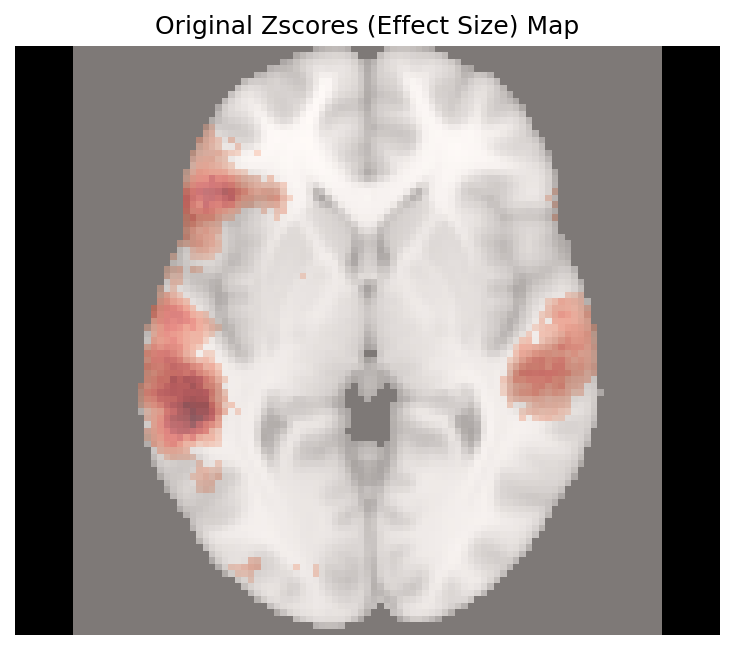

In [8]:
plot_images(anatomical, contrast_img, slice_idx, title="Original Zscores (Effect Size) Map")


# Stat P-Val Map

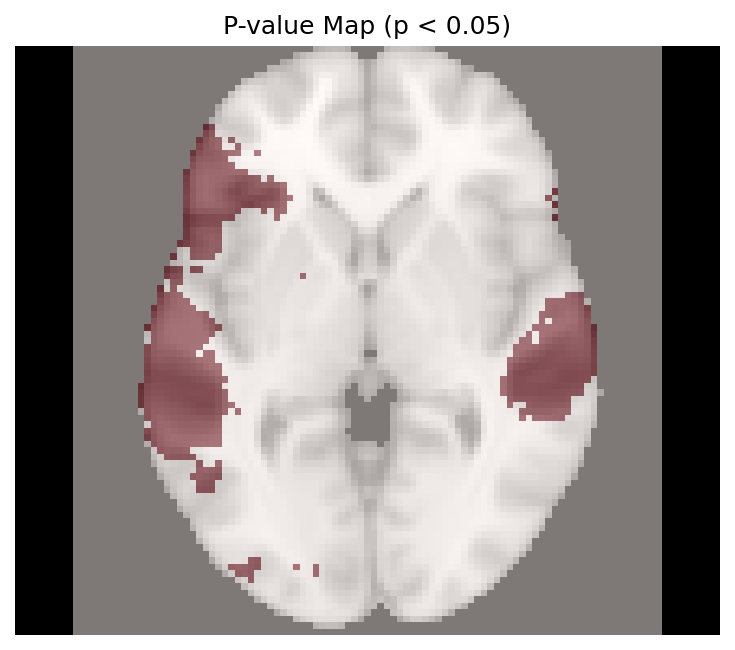

In [ ]:
# Compute two-tailed p-values
contrast_img_p = (1 - norm.cdf(np.abs(contrast_img))) # 1 tailed


# Get image dimensions correctly
XDIM, YDIM, ZDIM = contrast_img_p.shape
P_IMAGE = np.zeros((XDIM, YDIM, ZDIM))

for i in range(XDIM):
    for j in range(YDIM):
        for k in range(ZDIM):
                contrast_img_p_val = contrast_img_p[i, j, k]
                if contrast_img_p_val < 0.05:
                    P_IMAGE[i, j, k] = 1 - contrast_img_p_val #now "inverted" so stongest evidence against Ho (closest to 1)


plot_images(anatomical, P_IMAGE, slice_idx, title="P-value Map (p < 0.05)")

# Power Map

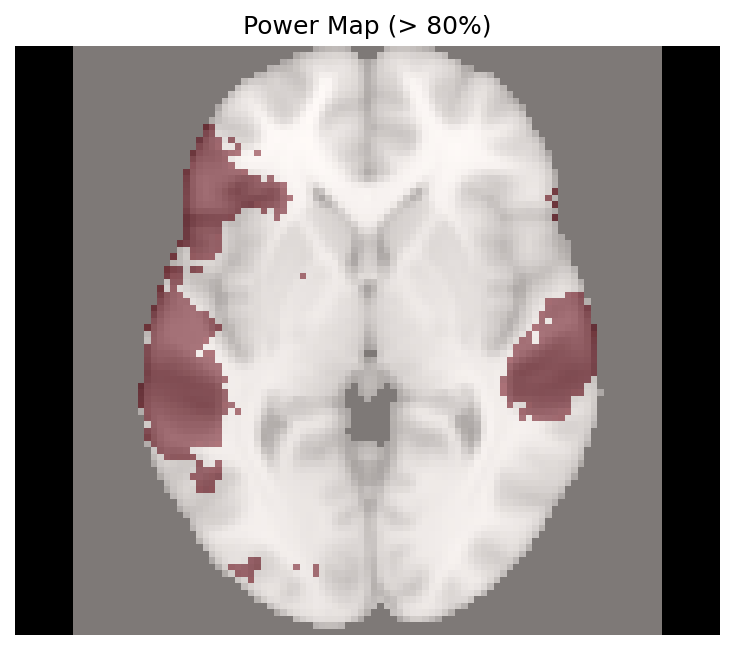

In [31]:
# Get image dimensions correctly
XDIM, YDIM, ZDIM = contrast_img.shape
PowerImage = np.zeros((XDIM, YDIM, ZDIM))

for i in range(XDIM):
    for j in range(YDIM):
        for k in range(ZDIM):
            if Contrast_Scaled[i, j, k] != 0:
                stat_power = power_calcs2(
                                    df1 = 1, 
                                    df2 = 300, 
                                    f2 = Contrast_Scaled[i, j, k],
                                    alpha = 0.05
                                    )
                if stat_power >= 0.8:
                                PowerImage[i, j, k] = stat_power


plot_images(anatomical, PowerImage, slice_idx, title = "Power Map (> 80%)")

# SGPV Map

/var/folders/s8/mm0m1zj51zn4xbw55t3kxv7h0000gn/T/ipykernel_55739/3217568249.py:28: RuntimeWarning: invalid value encountered in sqrt
  d = 2 * np.sqrt(f2) #in the case of 2 means (a t-test) according to Cohen's power book


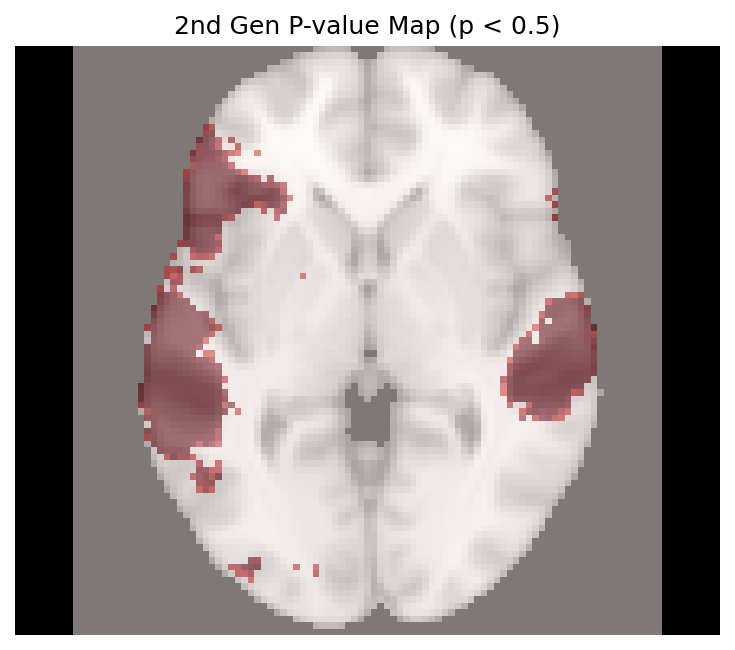

In [41]:
# Get image dimensions correctly
XDIM, YDIM, ZDIM = contrast_img.shape
PVal2Image = np.zeros((XDIM, YDIM, ZDIM))

for i in range(XDIM):
    for j in range(YDIM):
        for k in range(ZDIM):
            if contrast_img[i, j, k] != 0:
                contrast_img_2p = calculate_second_gen_p_value(observed_effect = contrast_img[i, j, k], 
                                               null_hypothesis = 0, 
                                               effect_interval = 2, 
                                               f2 = Contrast_Scaled[i, j, k], 
                                               n = 15, 
                                               alpha = 0.05, 
                                               df = 1, 
                                               verbose=False) # works better outside or for-loop (was originally only giving one value at a time)
                if contrast_img_2p < 0.5:
                    PVal2Image[i, j, k] = 1- contrast_img_2p #now "inverted" so stongest evidence against Ho (closest to 1)


plot_images(anatomical, PVal2Image, slice_idx, title="2nd Gen P-value Map (p < 0.5)")